# Machine Tool Wear Classfier

        1. This is a program to classify Machine Tool Wear using Time series Imaging by Gramian 
           Angular Summation Fields (GASF) and Deep Learning.

        2. Reference: Tool wear classification using time series imaging and deep learning.
                      by Giovanna Martínez-Arellano, German Terrazas & Svetan Ratchev,
                      The International Journal of Advanced Manufacturing Technology.

## Data

    1. Dataset was obtained from Kaggle Database.
       Dataset Link = https://www.kaggle.com/tobbyrui/phm2010

    2. The Dataset is a part of PHM 2010 Data Challenge.

    3. The Dataset contains Time Series data of Force in XYZ Directions, Vibrations in XYZ Directions 
       and Acoustic Emissions.

    4. This Dataset has 3 different End Mill Tool(6 mm with 3-Flute) Cutter Data.

    5. A Total of 315 Cuts were made by a single tool and its subsequent Force-Vibration-AE data were 
       taken and finally its wear was measured 315 times.

    6. Here only Force data was used for Time Series Imaging.

## Data Preprocessing

    1. There are 315 time series data of each cutting test with more than 200,000 recordings.

    2. Only force values in XYZ directions are taken for imaging.

    3. A window of 2100 sample values are taken and normalized as given in the reference paper.

    4. Then Piecewise Aggregate Approximation is done on these 1000 Normalized Data and it is 
       compressed to a window size of 250.

    5. After this, the compressed data is converted to polar form.

    6. GAF Image is obtained by using the logic(Temporal Correlation) given in the reference paper.

    7. GAF Images are obtained for all the XYZ Force Measurements and then it is combined into 
       a 3 channel image and saved.

### Import Libraries

In [1]:
import tensorflow as tf       # Tensorflow 
import numpy as np            # Numpy
import matplotlib.pyplot as plt # Matplotlib to plot
from tensorflow.keras.preprocessing.image import ImageDataGenerator # To process Image
import pandas as pd      # To make Dataframes
import time              # Time 
from matplotlib.image import imsave # Save Image
import cv2 # Open Cv2

In [18]:
from sklearn.metrics import classification_report, confusion_matrix # Confusion and Classification Report
import itertools  # itertools

### Gramian Angular Summation Field Force Image Generator

In [ ]:
class GenerateImages():
    
    def __init__(self, num_start, num_end, region=None):
        '''GenerateImages Constructor.
           Pass: Region Starting Number, Region Ending Number and Region Name.'''
        self.num_start = num_start
        self.num_end = num_end
        self.region = region
    
    def generate(self, m, n, drive_name):
        '''Generates GAF Image and saves a File.
           Pass: Integers of compressed GAF size, Sample Size and Drive Name. 
                 Eg.: generate(500, 2000, 'C1\c_1_').
           Returns: None.'''
        for it in range(self.num_start, self.num_end+1):
            # Note the Starting Time 
            start = time.time()
            # Logic To Extract the File Name From the Directory
            if it%10 == it:  # If i <= 9 i.e. i is a single digit number
                f = f'00{it}'
            elif it//10>=1 and it//10<=9: # If  i >=10 and i<=99 i.e. i is a double digit number.
                f = f'0{it}'
            else: # If  i >=100 and i<=999 i.e. i is a triple digit number.
                f = f'{it}'

            # Extract the File Name
            drive = f'{drive_name}{f}.csv'
            # Read the CSV File
            df = pd.read_csv(drive,header=None)
            num_images = int(df.shape[0]/n)
            n_train = int(num_images*0.75)
            n_valid = n_train + int(num_images*0.25)
            
            # Loop through the data frame
            for i in range(num_images):
                df_sample = df[i*n: (i+1)*n]  # Sample the Dataframe
                li_image = [] # List to store Images
                # Get image of X,Y,Z Forces
                for j in range(0,3):
                    force = np.array(df_sample[j]) # Extract the data
                    
                    # Normalize 
                    force_norm = ((force-np.max(force))+(force-np.min(force)))/(np.max(force) - np.min(force))
                    
                    # Piecewise Aggregate Approximation
                    force_paa = [] # List to store PAA Values
                    
                    for ii in range(1, m+1):           # Loop through m sets.
                        j1 = int((n/m)*(ii-1) + 1 - 1) # Limit Start
                        j2 = int((n/m)*ii -1)          # Limit End
                        li = []

                        for jj in range(j1, j2+1):  # Append the set of values which is in the summation block of PAA Formula
                            li.append(force_norm[jj]) # Append.
                        avg = (m/n)*(sum(li)) # Find the Average.
                        force_paa.append(avg) # Apppend the PAA Average data to Final List.
                    
                    # Polar Form
                    force_paa_polar = np.arccos(force_paa)
                    
                    # Produce GAF Image  
                    gaf_image = np.zeros((m,m)) # Zero Matrix with shape (m, m)
                    for k in range(gaf_image.shape[0]):
                        for l in range(gaf_image.shape[1]):
                            gaf_image[k,l] = np.cos(force_paa_polar[k] + force_paa_polar[l]) # GAF Formula
                    # Append to List
                    li_image.append(gaf_image)
                    
                # Merge the three channel images
                gaf_image_3 = cv2.merge((li_image[0], li_image[1], li_image[2]))
                gaf_image_3 = (gaf_image_3*255).astype('uint8')  # Convert to Integer format Range[0 ==> 255]
                
                # Save in Directories
                if i<=n_train:
                    imsave('Images/train/{}/{}{}_{}.jpg'.format(self.region, drive_name[3:], f, i), gaf_image_3, cmap = plt.cm.jet)
                elif i>n_train and i<=n_valid:
                    imsave('Images/valid/{}/{}{}_{}.jpg'.format(self.region, drive_name[3:], f, i), gaf_image_3, cmap = plt.cm.jet)
                
            end = time.time()
            print(it, '===>', 'ETA: ', end-start, 'sec')

#### Break-In Region

In [ ]:
genrate_image = GenerateImages(1, 50, 'break_in') # Instantiate
genrate_image.generate(250, 1000, 'C4\c_4_')      # Call Function

#### Steady Region

In [ ]:
genrate_image = GenerateImages(51, 175, 'steady') # Instantiate
genrate_image.generate(250, 1000, 'C4\c_4_')      # Call Function

#### Severe Region

In [ ]:
genrate_image = GenerateImages(176, 250, 'severe') # Instantiate
genrate_image.generate(250, 1000, 'C4\c_4_')       # Call Function

#### Failure Region

In [ ]:
genrate_image = GenerateImages(251, 315, 'failure') # Instantiate
genrate_image.generate(250, 1000, 'C4\c_4_')        # Call Function

#### Peek at the Images

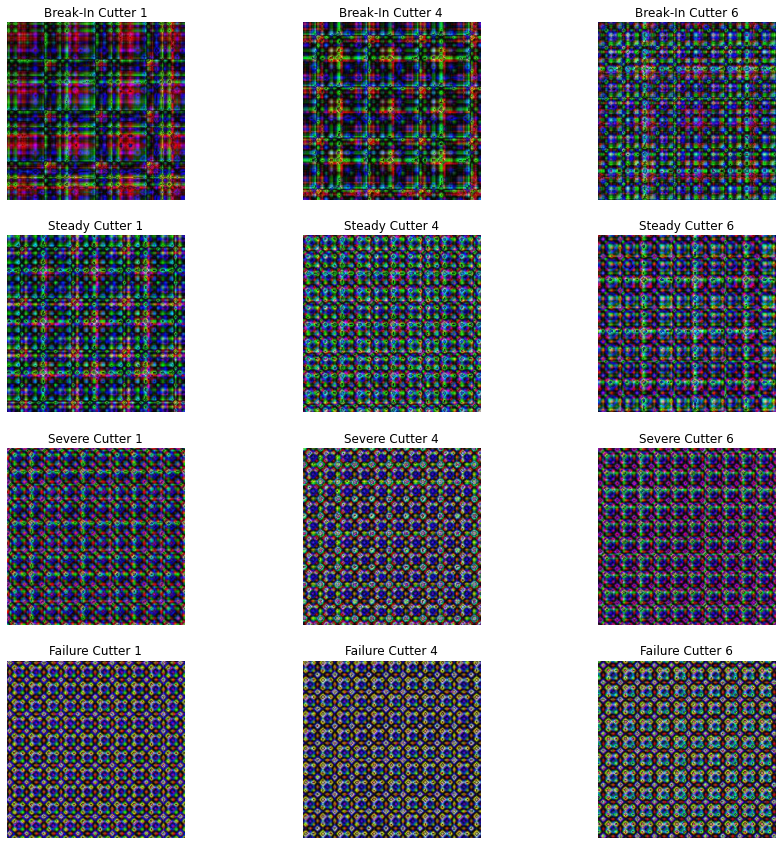

In [2]:
rows = 4  # No of Rows 
cols = 3  # No of columns

# List of Strings
list_images =['Images/train/break_in/c_1_002_50.jpg', 'Images/train/break_in/c_4_004_20.jpg', 'Images/train/break_in/c_6_003_2.jpg',
              'Images/train/steady/c_1_051_13.jpg', 'Images/train/steady/c_4_095_20.jpg', 'Images/train/steady/c_6_094_90.jpg',
              'Images/train/severe/c_1_176_13.jpg', 'Images/train/severe/c_4_231_107.jpg', 'Images/train/severe/c_6_199_54.jpg',
              'Images/train/failure/c_1_313_160.jpg', 'Images/train/failure/c_4_315_137.jpg', 'Images/train/failure/c_6_315_137.jpg',]

list_titles = ['Break-In Cutter 1', 'Break-In Cutter 4', 'Break-In Cutter 6', 'Steady Cutter 1', 'Steady Cutter 4', 
               'Steady Cutter 6', 'Severe Cutter 1', 'Severe Cutter 4', 'Severe Cutter 6', 'Failure Cutter 1', 
               'Failure Cutter 4', 'Failure Cutter 6']

# Figure using subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15), squeeze=0, sharex=True, sharey=True)
axes = np.array(axes)

j=0 # Iterator
for i, ax in enumerate(axes.reshape(-1)):
    img = plt.imread(list_images[j]) # Read Image
    ax.imshow(img)                   # Show Image 
    ax.set_title(list_titles[j])     # Set title
    ax.set_axis_off()                # Set Axis off
    j=j+1                            # Increment j


### How Train-Valid were split

In [52]:
df_split = pd.read_csv('C1/c_1_015.csv', header=None) # Read CSV File
df_split.head()

,0,1,2,3,4,5,6
0,5.120,0.336,-0.933,0.012,0.007,0.005,-0.004
1,5.203,0.289,-0.986,0.108,0.083,0.091,-0.004
2,5.241,0.192,-1.040,0.048,0.039,0.031,-0.005
3,5.278,0.168,-1.061,0.048,0.047,0.039,-0.005
4,5.288,0.109,-1.101,0.035,0.009,0.021,-0.005


In [56]:
train_line = np.array([int(df_split.shape[0]*0.75)]*100) # To plot Regions
y_array = np.linspace(-20,20,100)                   # To plot Regions
val_line = np.array([int(df_split.shape[0]*1.0)]*100)   # To plot Regions

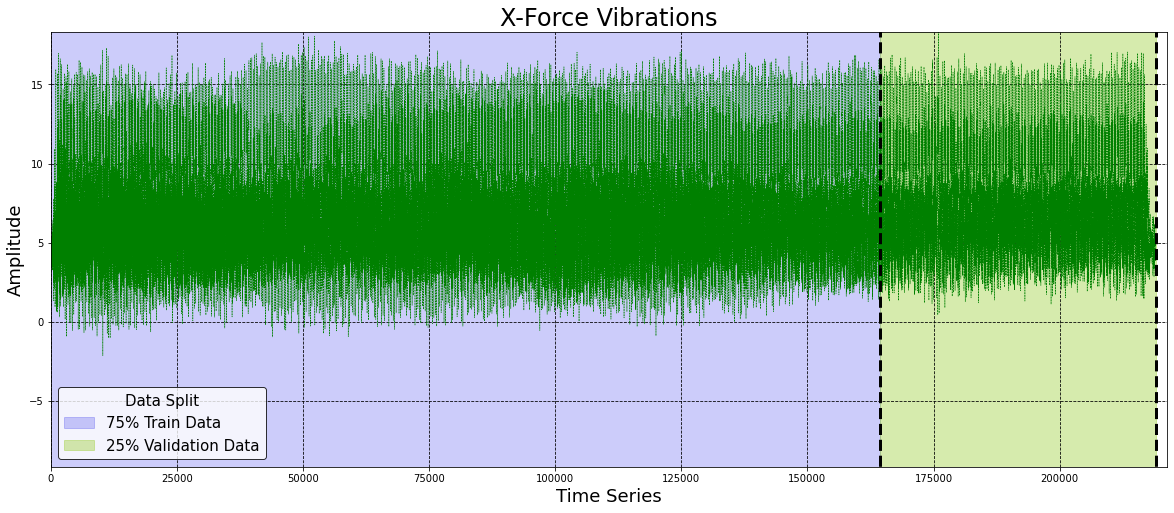

In [57]:
plt.figure(figsize = (20,8)) # Figure
plt.plot(df_split[0], 'green', linewidth=0.5, linestyle='dashed') # Plot
plt.plot(train_line, y_array, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.plot(val_line, y_array, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.fill_betweenx(y = y_array, x1=train_line, label='75% Train Data', color=[0.0,0.0,0.9,0.2]) # Fill color 
plt.fill_betweenx(y = y_array, x1=train_line, x2=val_line,label='25% Validation Data', color=[0.6039,0.8039,0.196,0.4]) # Fill color  
plt.title('X-Force Vibrations', fontdict={'fontsize':24}) # Title
plt.xlabel('Time Series', fontdict={'fontsize':18}) # X-label
plt.ylabel('Amplitude', fontdict={'fontsize':18}) # Y-label
plt.xlim((0,int(df_split.shape[0]+0.01*int(df_split.shape[0])))) # Set x-limit
plt.ylim((-np.max(df_split[0])*0.5,np.max(df_split[0]))) # Set y-limit
plt.grid(True, color='black', linestyle='--') # Grid
plt.legend(fontsize=15, title='Data Split', loc=0, edgecolor='black', title_fontsize=15) # Legend
plt.show() # Show

### Wear Classification

#### Read Wear Data

In [3]:
wear_c1 = pd.read_csv('C1/c1_wear.csv') # Read the CSV File
wear_c4 = pd.read_csv('C4/c4_wear.csv') # Read the CSV File
wear_c6 = pd.read_csv('C6/c6_wear.csv') # Read the CSV File
wear_c1.head() # Read the First 5 Rows

,cut,flute_1,flute_2,flute_3
0,1,32.317114,48.892617,37.720825
1,2,37.914879,49.570815,37.720825
2,3,43.087910,50.302867,37.720825
3,4,47.859072,51.083652,37.849851
4,5,52.250329,51.908288,38.172665


#### Drop columns

In [4]:
wear_c1 = wear_c1.drop(labels=['cut'], axis = 1) # Drop the Cut Column
wear_c4 = wear_c4.drop(labels=['cut'], axis = 1) # Drop the Cut Column
wear_c6 = wear_c6.drop(labels=['cut'], axis = 1) # Drop the Cut Column
wear_c4.head()  # Read the First 5 Rows

,flute_1,flute_2,flute_3
0,31.416355,19.483692,21.748063
1,34.892770,23.473047,24.925960
2,38.102847,27.172868,27.898659
3,41.061023,30.599309,30.677848
4,43.781191,33.767870,33.274721


#### Get the maximum wear

In [5]:
wear_c1['Max. Wear'] = wear_c1.max(axis = 1) # Find the Maximum of the three flutes wear in microns.
wear_c4['Max. Wear'] = wear_c4.max(axis = 1) # Find the Maximum of the three flutes wear in microns.
wear_c6['Max. Wear'] = wear_c6.max(axis = 1) # Find the Maximum of the three flutes wear in microns.
wear_c6.head()  # Read the First 5 Rows

,flute_1,flute_2,flute_3,Max. Wear
0,62.788648,9.896641,14.620908,62.788648
1,64.136043,19.793281,29.241817,64.136043
2,65.365273,29.689922,43.862725,65.365273
3,66.486880,39.586563,58.483634,66.486880
4,67.510808,43.019994,59.345759,67.510808


#### Print the Minimum and Maximum wear

In [6]:
print(f"Maximum and Minumum Wear in C1 is {np.max(wear_c1['Max. Wear'])} and {np.min(wear_c1['Max. Wear'])}")
print(f"Maximum and Minumum Wear in C4 is {np.max(wear_c4['Max. Wear'])} and {np.min(wear_c4['Max. Wear'])}")
print(f"Maximum and Minumum Wear in C6 is {np.max(wear_c6['Max. Wear'])} and {np.min(wear_c6['Max. Wear'])}")

Maximum and Minumum Wear in C1 is 172.6868372 and 48.89261732
Maximum and Minumum Wear in C4 is 210.9193705 and 31.41635516
Maximum and Minumum Wear in C6 is 234.7159485 and 62.78864802


#### Parameters for plotting

In [7]:
wear_limits = np.linspace(25, 240, num = 50) # To plot Regions
cut_50 = np.array([50]*50)   # To plot Regions
cut_175 = np.array([175]*50) # To plot Regions
cut_250 = np.array([250]*50) # To plot Regions
cut_315 = np.array([315]*50) # To plot Regions

#### Plot Tool Flank Wear as a function Cutting Test

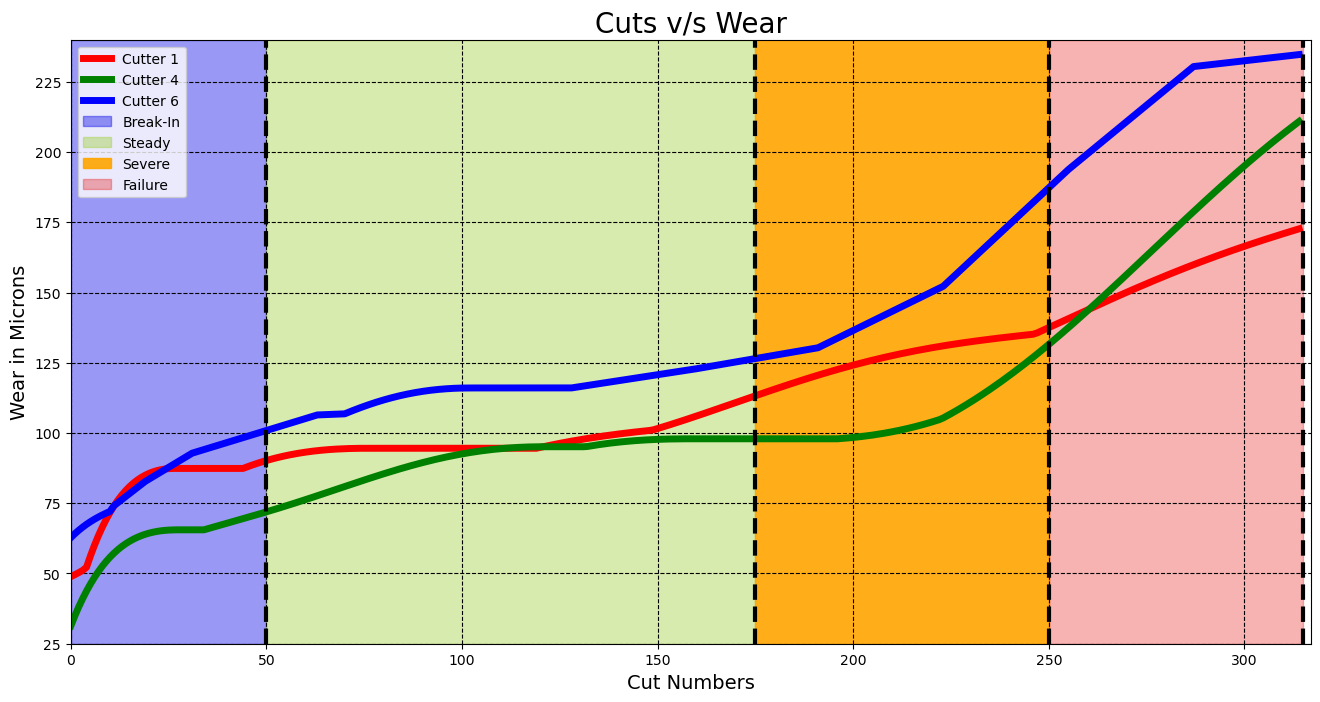

In [8]:
plt.figure(figsize=(16,8), edgecolor='black', dpi = 100) # Figure
plt.plot(wear_c1['Max. Wear'], color = 'red', label='Cutter 1', linewidth=5, linestyle='-') # Plot
plt.plot(wear_c4['Max. Wear'], color = 'green', label='Cutter 4', linewidth=5) # Plot
plt.plot(wear_c6['Max. Wear'], color = 'blue', label='Cutter 6', linewidth=5) # Plot
plt.plot(cut_50, wear_limits, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.plot(cut_175, wear_limits, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.plot(cut_250, wear_limits, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.plot(cut_315, wear_limits, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.xlim((0,317)) # Set x-limit
plt.ylim((25,240)) # Set y-limit
plt.fill_betweenx(y = wear_limits, x1=cut_50, label='Break-In', color=[0.0,0.0,0.9,0.4]) # Fill color 
plt.fill_betweenx(y = wear_limits, x1=cut_50, x2=cut_175,label='Steady', color=[0.6039,0.8039,0.196,0.4]) # Fill color 
plt.fill_betweenx(y = wear_limits, x1=cut_175, x2=cut_250, label ='Severe', color=[1.0,0.647,0.0,0.9])# Fill color 
plt.fill_betweenx(y = wear_limits, x1=cut_250, x2=cut_315, label='Failure', color=[0.9,0.0,0.0,0.3])  # Fill color 
plt.xlabel('Cut Numbers', fontdict={'fontsize':14}) # x-label
plt.ylabel('Wear in Microns', fontdict={'fontsize':14}) # y-label
plt.title('Cuts v/s Wear', fontdict={'fontsize':20}) # Title
plt.grid(True, color='black', linestyle='--') # Grid
plt.legend() # Legend
plt.show() # Show

### Note:
        1. There are 4 important regions in Tool Wear.
        2. They are Break-In Wear, Steady Wear, Severe Wear and Failure Wear.
        3. These are shown in the plot above.
        4. Here:
                a. From Cut 001 ==> Cut 050 is defined as ==> Break-In Wear.
                b. From Cut 051 ==> Cut 175 is defined as ==> Steady Wear.
                c. From Cut 176 ==> Cut 250 is defined as ==> Severe Wear.
                d. From Cut 251 ==> Cut 315 is defined as ==> Failure Wear.

## Tool Wear Classifier

#### Define Parameters

In [9]:
train_batch = 100   # Train Batch.
valid_batch = 100   # Test Batch.
size_image = 250   # Size of Image.
num_classes = 4    # Number of classes to be classfied.
dir_train = 'Images/train/' # Directory of Train Set.
dir_valid = 'Images/valid/' # Directory of Validation Set.
img_resize = 150 # Resize 

#### Instantiate ImageDataGenerator()

In [10]:
data_generator = ImageDataGenerator()# Object of ImageDataGenerator()

#### Train set

In [11]:
train = data_generator.flow_from_directory(directory=dir_train, batch_size=train_batch,
                                           class_mode='categorical', target_size = (size_image, size_image))

Found 156849 images belonging to 4 classes.


#### Validation Set

In [12]:
valid = data_generator.flow_from_directory(directory=dir_valid, batch_size=valid_batch, shuffle=False,
                                           class_mode='categorical', target_size = (size_image, size_image))

Found 51321 images belonging to 4 classes.


#### Define Model

In [19]:
model = tf.keras.Sequential(name='Tool_Wear_Classifier')
model.add(tf.keras.layers.InputLayer(input_shape=(size_image, size_image, 3), name='Input_Layer'))
model.add(tf.keras.layers.experimental.preprocessing.Resizing(img_resize, img_resize, name='Resizer'))
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, name='Rescaler'))
    
model.add(tf.keras.layers.Conv2D(64, 7,activation='relu', padding="valid", name='Convolution_1'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(4,4), padding = 'valid', name='Pooling_1'))
model.add(tf.keras.layers.BatchNormalization(name='Batch_Normalizer'))

model.add(tf.keras.layers.Conv2D(64, 7,activation='relu', padding="valid", name='Convolution_2'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(4, 4), padding = 'valid', name='Pooling_2'))
    
model.add(tf.keras.layers.Flatten(name='Flatten'))

model.add(tf.keras.layers.Dense(192, activation='relu', name='Dense_1'))
model.add(tf.keras.layers.Dropout(0.2, name='Dropout_1'))

model.add(tf.keras.layers.Dense(84, activation = 'relu', name='Dense_2'))
model.add(tf.keras.layers.Dropout(0.2, name='Dropout_2'))

model.add(tf.keras.layers.Dense(16, activation='relu', name='Dense_3'))

model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name='Classifier'))

#### Summarize

In [20]:
model.summary()

Model: "Tool_Wear_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Resizer (Resizing)           (None, 150, 150, 3)       0         
_________________________________________________________________
Rescaler (Rescaling)         (None, 150, 150, 3)       0         
_________________________________________________________________
Convolution_1 (Conv2D)       (None, 144, 144, 64)      9472      
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 36, 36, 64)        0         
_________________________________________________________________
Batch_Normalizer (BatchNorma (None, 36, 36, 64)        256       
_________________________________________________________________
Convolution_2 (Conv2D)       (None, 30, 30, 64)        200768    
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 7, 7, 64) 

#### Define Optimizer, Loss and Metrics

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Optimizer
loss_function = tf.keras.losses.CategoricalCrossentropy() # Loss Function
accuracy = tf.keras.metrics.CategoricalAccuracy() # Metric

#### Compile

In [ ]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy]) # Compile Model

In [ ]:
steps_per_epoch_train = len(train)
steps_per_epoch_valid = len(valid)

#### CSVLogger Callback

In [ ]:
csv_logger = tf.keras.callbacks.CSVLogger('Tool_Wear_Classfier.csv')

#### Custom Callback to Stop Training when Accuracy Reaches Threshold

In [ ]:
# Callback to stop training when validation set reaches threshold
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_categorical_accuracy"]
        if accuracy >= self.point:
            print('Stopping Training! Accuracy Reached')
            self.model.stop_training = True

# Call
stop_on_point = StopOnPoint(0.95)  

#### Define Epochs

In [ ]:
num_epochs = 10 # Number of Epochs

### Train Model

In [ ]:
history = model.fit(train, epochs=num_epochs, verbose=1, validation_data=valid,
                    steps_per_epoch = steps_per_epoch_train,
                    callbacks = [csv_logger, stop_on_point])# Fit Model

#### Save Model

In [ ]:
tf.keras.models.save_model(model, 'Tool_Wear_Classfier.model', include_optimizer=True, overwrite=True)

#### Plot Loss and Accuracy

In [13]:
history = pd.read_csv('Tool_Wear_Classfier.csv') # Read CSV File
history.head(10)

,epoch,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0,0.894051,0.259612,0.818460,0.533846
1,1,0.954077,0.119710,0.766969,0.706282
2,2,0.960554,0.100405,0.895604,0.255363
3,3,0.964896,0.091553,0.877658,0.383292
4,4,0.968530,0.081732,0.858175,0.455450
5,5,0.969487,0.079129,0.867036,0.504218
6,6,0.972617,0.071479,0.918911,0.253069
7,7,0.974192,0.068471,0.799907,1.346509
8,8,0.976468,0.062258,0.910191,0.535839
9,9,0.978891,0.056943,0.908249,0.510947


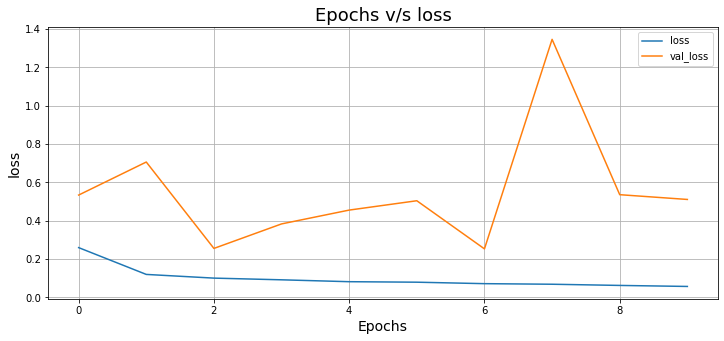

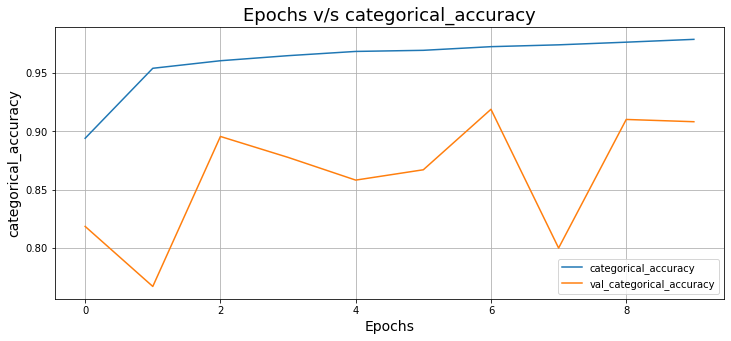

In [14]:
def plot(history, string):
    plt.figure(figsize = (12,5))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
    plt.plot(history[string], label = string)
    plt.plot(history['val_'+string], label = 'val_'+string)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Epochs', fontdict={'fontsize':14})
    plt.ylabel(string, fontdict={'fontsize':14})
    plt.title(f'Epochs v/s {string}', fontdict={'fontsize':18})
    plt.show()

# Call
plot(history, 'loss')
plot(history, 'categorical_accuracy')

### Prediction

#### Load Model

In [15]:
model = tf.keras.models.load_model('Tool_Wear_Classfier.model') # Load

#### Predict on Validation set

In [17]:
y_pred = model.predict(valid, verbose=1) # Predict

514/514 [==============================] - 1030s 2s/step


#### Helper Function

In [16]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [175]:
def predict(img, img_r, region=None):
    '''Predicts the class of the image.
       Pass: Image, Resized Tensor Image, Region.'''
    print(f'Reality: The tool is in {color.BOLD} {color.PURPLE} {region} {color.END} mode!')
    print('***********************************************************************************************')
    # Plot image
    plt.figure(figsize=(6,6)) # Figure
    plt.imshow(img) # Plot Image
    plt.axis('off')# Axes off
    plt.show() # Show image
    
    # Predict
    img = np.expand_dims(img_r, axis=0) # Expands into a 4-D array as CNN expects 4-D Array
    prediction = model.predict(img)   # Predict 
    index = prediction.argmax() # Get the index of highest probability.
    wear_mode = class_dict[index] # Get the class of wear

    print(f'''Prediction: The tool is in {color.BOLD}{color.GREEN} {wear_mode.capitalize()} Wear{color.END} mode!''') # Print
    print(f'Prediction Accuracy: {color.BOLD} {np.around(prediction[0][index]*100,2)}% {color.END}') # Print
    print('***********************************************************************************************')

In [36]:
# Get Class Names and its Indices
class_dict = valid.class_indices # Dictionary
print('Original: ', class_dict)

# Invert the dictionary
class_dict = dict((values, key) for key,values in class_dict.items())
print('Reversed: ', class_dict)

Original:  {'break_in': 0, 'failure': 1, 'severe': 2, 'steady': 3}
Reversed:  {0: 'break_in', 1: 'failure', 2: 'severe', 3: 'steady'}


#### Predict Break-In

Reality: The tool is in   Break-In Wear  mode!
***********************************************************************************************


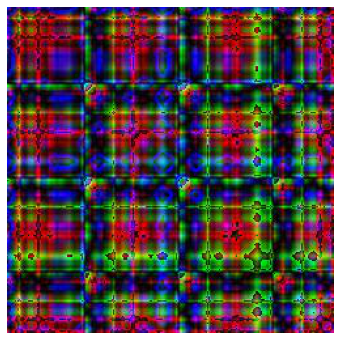

Prediction: The tool is in  Break_in Wear mode!
Prediction Accuracy:  93.18% 
***********************************************************************************************


In [176]:
img_dir = 'Images/valid/break_in/c_1_002_168.jpg' # Image directory
img = plt.imread(img_dir) # Read Image
img_r = tf.image.resize(img, (150,150)) # Resize image 'bilinear'

# Predict
predict(img, img_r, 'Break-In Wear')

#### Predict Steady 

Reality: The tool is in   Steady Wear  mode!
***********************************************************************************************


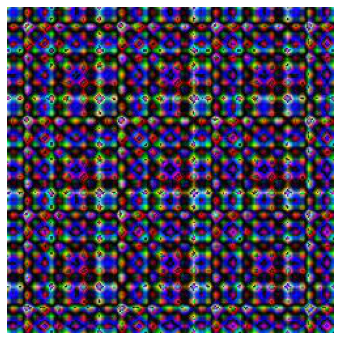

Prediction: The tool is in  Steady Wear mode!
Prediction Accuracy:  100.0% 
***********************************************************************************************


In [177]:
img_dir = 'Images/valid/steady/c_4_133_210.jpg' # Image directory
img = plt.imread(img_dir) # Read Image
img_r = tf.image.resize(img, (150,150)) # Resize image 'bilinear'

# Predict
predict(img, img_r, 'Steady Wear')

#### Predict Severe 

Reality: The tool is in   Severe Wear  mode!
***********************************************************************************************


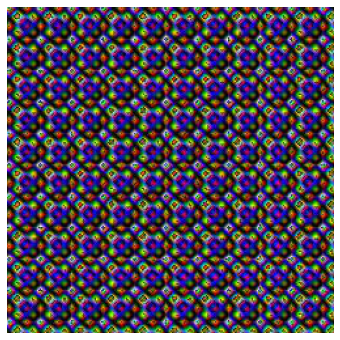

Prediction: The tool is in  Severe Wear mode!
Prediction Accuracy:  99.97% 
***********************************************************************************************


In [178]:
img_dir = 'Images/valid/severe/c_1_247_206.jpg' # Image directory
img = plt.imread(img_dir) # Read Image
img_r = tf.image.resize(img, (150,150)) # Resize image 'bilinear'

# Predict
predict(img, img_r, 'Severe Wear')

#### Predict Failure

Reality: The tool is in   Failure Wear  mode!
***********************************************************************************************


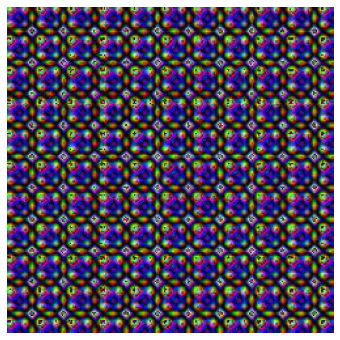

Prediction: The tool is in  Failure Wear mode!
Prediction Accuracy:  100.0% 
***********************************************************************************************


In [179]:
img_dir = 'Images/valid/failure/c_6_315_188.jpg' # Image directory
img = plt.imread(img_dir) # Read Image
img_r = tf.image.resize(img, (150,150)) # Resize image 'bilinear'

# Predict
predict(img, img_r, 'Failure Wear')

### Confusion Matrix

In [19]:
y_pred = np.argmax(y_pred, axis=1) # Get the index maximum probability

In [32]:
# Get the names of labels for confusion Matrix
target_names = []
for key in valid.class_indices:
    target_names.append(key.capitalize())

#### Helper Function to Plot Confusion MAtrix

In [33]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    """ This function prints and plots the confusion matrix. """

    plt.figure(figsize=(10,10)) # Figure 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # Plot Image
    plt.title(title, fontdict={'fontsize':24}) # Title
    plt.colorbar()   # Show Colorbar
    tick_marks = np.arange(len(classes)) # Array with elements as nuber of classes i.e. [0,1,2,3,4]
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14, fontweight='semibold') # X-Ticks as class names
    plt.yticks(tick_marks, classes, fontsize=14, fontweight='semibold') # Y-Ticks as class names
    
    
    # Show the number of classified images in the Confusion Matrix Box
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black", fontsize=14, fontweight='semibold')
    
    plt.tight_layout() # Tight Layout
    plt.ylabel('True label', fontdict={'fontsize':18}) # Y-label
    plt.xlabel('Predicted label', fontdict={'fontsize':18}) # X-label
    plt.show() # Show 

#### Confusion Matrix

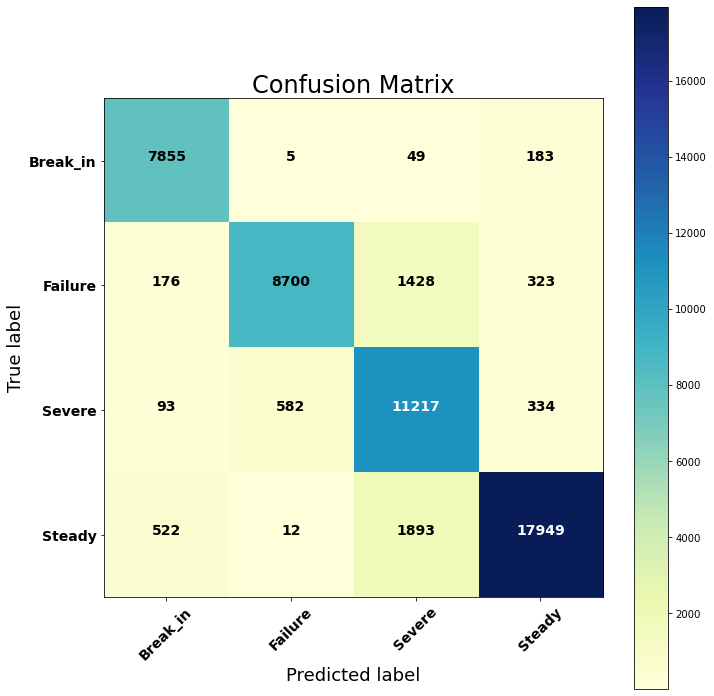

In [34]:
cm = confusion_matrix(valid.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

### Classification Report

In [27]:
print('Classification Report')
print(classification_report(valid.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    break_in       0.91      0.97      0.94      8092
     failure       0.94      0.82      0.87     10627
      severe       0.77      0.92      0.84     12226
      steady       0.96      0.88      0.92     20376

    accuracy                           0.89     51321
   macro avg       0.89      0.90      0.89     51321
weighted avg       0.90      0.89      0.89     51321



# -------------------------------------------------------------------------------------------------------------